# Analysing survey feedback using topic modelling

The goal of this project was to demonstrate topic analyses on text comments from university students using Apache Spark. Topic analysis was conducted using Latent Dirichlet Allocation (LDA).

**Why?**

Universities have a moral and regulatory obligation to provide students with an optimal teaching and learning experience. It is commonplace to use student feedback, collected via a broad range of institutional and nationwide surveys, to optimise delivery. This involves manual analyses of text comments which is slow, labour intensive and at risk of confirmation bias. If analyses was automated using machine learning and distributed computing techniques, then both the validity and efficiency of findings could be improved which, in-turn, could lead to improvements in the student experience.

## Scope

This proof of concept study is limited to the National Student Survey (NSS) for three reasons. Firstly, it is the largest survey of UK students. Secondly, it is used by the Office for Students to benchmark student satisfaction and ensure quality and standard requirements are met. Finally, NSS results feed into all domestic University league tables, which are important to institutional reputation and prospective students’ application choices.

LDA was chosen for three reasons. Firstly, documents can be associated with more than one topic. This is advantageous as comments frequently include references to multiple aspects of the student experience. Secondly, it is an unsupervised algorithm. This meant manual labelling of comments was unnecessary. Finally, LDA is supported by the PySpark library. This enabled development of a workflow appropriate for distributed computing.

## Background

* Latent Dirichlet Allocation (LDA) is a probabilistic model used for topic modeling in text data.

    **Note:** The number of topics is a hyperparameter.

* It is a form of soft clustering because it assigns a probability distribution of topics to each document, allowing for the possibility of multiple topics contributing to a single document.

    **Note:** In traditional hard clustering, each data point (document in the case of LDA) is assigned to a single cluster, resulting in a clear, exclusive partitioning.

* It learns two main things:

    1. **_Document-Topic Distribution_** (i.e. documents are mixtures of topics)

        $P(\theta_d | \alpha) = \frac{1}{B(\alpha)} \prod_{i=1}^{K} \theta_{di}^{\alpha_i - 1}$

        *Where, $K$is the number of topics, $\theta_d$ is the topic distribution for document $d$, $\alpha$ is the Dirichlet hyperparameter vector and $B(\alpha)$ is the multivariate Beta function.*

    2. **_Topic-Word Distribution_** (i.e. topics are mixtures of words)
 
        $P(\phi_k | \beta) = \frac{1}{B(\beta)} \prod_{i=1}^{V} \phi_{ki}^{\beta_i - 1}$

        *Where, $\phi_k$ is the word distribution for topic $k$, $\beta$ is the Dirichlet hyperparameter for the word distribution, $V$ is the vocabulary size and $B(\beta)$ is the multivariate Beta function.*

# Set up

## Google Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
import os

# This will prompt for authorization.
drive.mount('/content/drive')

# Cd to relevant google drive directory
# Note: Run a shell command using os.system
os.chdir("/content/drive/MyDrive/Colab Notebooks/Summer project")

Mounted at /content/drive


## Spark

In [ ]:
# Install PySpark and Spark NLP
# Source: https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32
! pip install -q pyspark==3.1.2 spark-nlp

import sparknlp
spark = sparknlp.start()
sparknlp.start(gpu=True)
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.4/453.4 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 19.1 MB/s eta 0:00:00
Spark NLP version 4.2.6
Apache Spark version: 3.1.2


In [ ]:
# Start spark session
spark = sparknlp.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dependencies

In [ ]:
import pandas as pd
import chardet
import numpy as np
import re
! pip install nltk # Install nltk

## Import data

In [ ]:
### Upload files from google drive directory
%cd "/content/drive/MyDrive/Colab Notebooks/Summer project"

# Determine encoding of file
# Source: https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
with open('2017-2022 NSS Comments.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# Upload comments
CommentsRaw = pd.read_csv('2017-2022 NSS Comments.csv',encoding=result['encoding'])
CommentsRaw.head()

/content


,Year,Department 1,Negative comment,Positive comment,School
0,2021,AHUHSC,Disorganised ineligible.,Ineligible.,SHPS
1,2021,AHUHSC,Some lecturers take longer than usual to answe...,They have adapted well to lockdown and making ...,SHPS
2,2021,AHUHSC,"The course is badly advertise, it's very unorg...","The course gives a wide range of topics, a lot...",SHPS
3,2021,AHUHSC,No nothing.,No nothing.,SHPS
4,2021,AHUHSC,Did not have enough lectures to be satisfied. ...,NaN,SHPS


In [ ]:
# Reshape comments, add target and remove missing data

# Reshape
negComments = CommentsRaw.loc[:,['Year', 'Department 1', 'Negative comment', 'School']].\
reset_index().\
rename(columns={'Year':'year', 'Department 1': 'course', 'Negative comment': 'comment', 'index':'id'})

posComments = CommentsRaw.loc[:,['Year', 'Department 1', 'Positive comment', 'School']].\
reset_index().\
rename(columns={'Year':'year', 'Department 1': 'course', 'Positive comment': 'comment', 'index':'id'})

# Target
negComments['sentiment']='Negative'
posComments['sentiment']='Positive'

# Filter missing data
negComments = negComments[~negComments['comment'].isna()]
posComments = posComments[~posComments['comment'].isna()]

print(negComments.shape)
print(posComments.shape)

# Filter comments just stating "No nothing"/ "None" / "Na"
terms = ["None.",
         "N/A",
         "No.",
         "Nothing.",
         "NONE",
         "No",
         "N/A.",
         "Nothing",
         "No negatives.",
         "Not really",
         "No not really",
         "Na",
         "NIL",
         "No comment.",
         "None.",
         "No.",
         "N/A",
         "Nothing.",
         "NO",
         "N/A.",
         "None",
         "Not really",
         "No nothing.",
         "nan",
         "no",
         "N/a",
         "none",
         "2",
         "Not really.",
         "???.",
         "1",
         "None that I can think of.",
         "There are no positives.",
         "x",
         "NOTHING TO ADD",
         "Nothing comes to mind.",
         "Nothing to mention.",
         "no not really",
         "Nope.",
         "Non.",
         "Don't know.",
         "No not really.",
         "Good.",
         "Positive",
         "Good experience.",
         "Very good.",
         "Nothing at all."]

negComments = negComments[~negComments['comment'].isin(terms)]
posComments = posComments[~posComments['comment'].isin(terms)]

# Filter covid years
negComments = negComments[(negComments['year']==2021) | (negComments['year']==2022)]
posComments = posComments[(posComments['year']==2021) | (posComments['year']==2022)]

# Filter School
negComments = negComments[(negComments['School']=="Bayes")]
posComments = posComments[(posComments['School']=="Bayes")]

# Reset index
negComments = negComments.reset_index(drop=True)
posComments = posComments.reset_index(drop=True)

# Concatenate
comments = pd.concat([negComments, posComments],axis=0)
comments = comments.reset_index(drop=True)
comments.head()

(4613, 6)
(4727, 6)


,id,year,course,comment,School,sentiment
0,10,2021,ASUASC,Some of the lecturer didn't provide much infor...,Bayes,Negative
1,11,2021,ASUASC,Don't know why lecturers can get so slow with ...,Bayes,Negative
2,15,2021,ASUASC,Some lecture slides and notes are hard to unde...,Bayes,Negative
3,16,2021,ASUASC,Some lecturers not as good at teaching as others.,Bayes,Negative
4,17,2021,ASUASC,Some lecturers can be very vague with what the...,Bayes,Negative


# Topic modeling via LDA (soft clustering)

Code adaped from:
* https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb
* https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e

## Data prep

In [ ]:
# input_comments = negComments
input_comments = posComments
num_topics = 2
N = 3 # N-gram

In [ ]:
lda_data = spark.createDataFrame(input_comments[['year', 'course', 'comment', 'sentiment']])
lda_data.show(5, truncate = 100)

+----+------+----------------------------------------------------------------------------------------------------+---------+
|year|course|                                                                                             comment|sentiment|
+----+------+----------------------------------------------------------------------------------------------------+---------+
|2021|ASUASC|I like some of my tutors who provided all the past papers and a lot of questions to practice even...| Positive|
|2021|ASUASC|                                                                Very smoothly run, despite lockdown.| Positive|
|2021|ASUASC|There are enough resources available for students for most modules. Lecturers are always availabl...| Positive|
|2021|ASUASC|                                               Done internship and can apply what he's/she's learnt.| Positive|
|2021|ASUASC|The quality of teaching for some lecturers, they know what they are teaching; they can also highl...| Positive|


In [ ]:
# Filter comments
from pyspark.sql import functions as func
col = 'comment'
lda_data = lda_data.select(col).filter(func.col(col).isNotNull())
lda_data.show(5, truncate = 100)

+----------------------------------------------------------------------------------------------------+
|                                                                                             comment|
+----------------------------------------------------------------------------------------------------+
|I like some of my tutors who provided all the past papers and a lot of questions to practice even...|
|                                                                Very smoothly run, despite lockdown.|
|There are enough resources available for students for most modules. Lecturers are always availabl...|
|                                               Done internship and can apply what he's/she's learnt.|
|The quality of teaching for some lecturers, they know what they are teaching; they can also highl...|
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



### Pipeline 1: Tokenization & Normalization

In [ ]:
# Configure pipeline
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline

# Prepares data into a format that is processable by Spark NLP.
# https://nlp.johnsnowlabs.com/docs/en/annotators#documentassembler
documentAssembler = DocumentAssembler().setInputCol('comment').setOutputCol('document')

# Tokenizes raw text in document type columns into TokenizedSentence.
# https://nlp.johnsnowlabs.com/docs/en/annotators#tokenizer
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/token/tokenizer/index.html
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('tokenized')

# Removes all punctuation (by default)
# https://nlp.johnsnowlabs.com/docs/en/annotators#normalizer
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/normalizer/index.html
normalizer = Normalizer().setInputCols(['tokenized']).setOutputCol('normalized').setLowercase(True)

# Output results into an array
# https://nlp.johnsnowlabs.com/docs/en/concepts#finisher-getting-data-out
finisher = Finisher().setInputCols(['normalized'])

# Pipeline
pipeline = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 finisher,
                 ])

# Train the estimators and transform the data using the entire pipeline
processed_comments = pipeline.fit(lda_data).transform(lda_data)
processed_comments.show(5, truncate=50)

+--------------------------------------------------+--------------------------------------------------+
|                                           comment|                               finished_normalized|
+--------------------------------------------------+--------------------------------------------------+
|I like some of my tutors who provided all the p...|[i, like, some, of, my, tutors, who, provided, ...|
|              Very smoothly run, despite lockdown.|          [very, smoothly, run, despite, lockdown]|
|There are enough resources available for studen...|[there, are, enough, resources, available, for,...|
|Done internship and can apply what he's/she's l...|[done, internship, and, can, apply, what, hessh...|
|The quality of teaching for some lecturers, the...|[the, quality, of, teaching, for, some, lecture...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows



### POS tagging

In [ ]:
# POS tagging with NLTK
import nltk
nltk.download('averaged_perceptron_tagger')
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf

pos_tagger = lambda words: [x[1] for x in nltk.pos_tag(words)]
pos_tagger_udf = udf(pos_tagger, ArrayType(StringType()))

# Apply function
processed_comments = processed_comments.withColumn('pos', pos_tagger_udf(processed_comments.finished_normalized))
processed_comments.show(5, truncate=100)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                             comment|                                                                                 finished_normalized|                                                                                                 pos|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|I like some of my tutors who provided all the past papers and a lot of questions to 

### Lemmatize

In [ ]:
# Lemmatize adjectives, adverbs, nouns and verbs with NLTK - pass POS tag to lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

# UDF
def lemmatize_tokens(words, tags):
  lemmas = []
  for word, pos in zip(words,tags):
    if pos.startswith('J'):
      lemmas.append(lemmatizer.lemmatize(word, 'a'))
    elif pos.startswith('N'):
      lemmas.append(lemmatizer.lemmatize(word, 'n'))
    elif pos.startswith('V'):
      lemmas.append(lemmatizer.lemmatize(word, 'v'))
    elif pos.startswith('R'):
      lemmas.append(lemmatizer.lemmatize(word, 'r'))
    else:
      lemmas.append(word)
  return lemmas

lemmatize_tokens_udf = udf(lemmatize_tokens, ArrayType(StringType()))

# Apply UDF
processed_comments = processed_comments.withColumn('lemmas', lemmatize_tokens_udf(processed_comments.finished_normalized, processed_comments.pos))
processed_comments.show(5, truncate=100)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                             comment|                                                                                 finished_normalized|                                                                                                 pos|                                                                                              lemmas|
+----------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------

### Drop stop words and relevant POS tags

In [ ]:
### Remove stop words and relevant POS tags
from nltk.corpus import stopwords

# Stop words
nltk.download('stopwords')
stops = list(stopwords.words('english'))

# Remove stop word POS tags
stop_pos_remover = lambda words, tags: [pos for w, pos in zip(words, tags) if w not in stops]
stop_pos_remover_udf = udf(stop_pos_remover, ArrayType(StringType()))
processed_comments = processed_comments.withColumn('pos', stop_pos_remover_udf(processed_comments.lemmas, processed_comments.pos))

# Remove stop words
stop_remover = lambda words: [w for w in words if w not in stops]
stop_remover_udf = udf(stop_remover, ArrayType(StringType()))
processed_comments = processed_comments.withColumn('lemmas', stop_remover_udf(processed_comments.lemmas))

processed_comments.show(5, truncate=50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                           comment|                               finished_normalized|                                               pos|                                            lemmas|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|I like some of my tutors who provided all the p...|[i, like, some, of, my, tutors, who, provided, ...|[IN, NNS, VBD, JJ, NNS, NN, NNS, NN, RB, JJ, NN...|[like, tutor, provide, past, paper, lot, questi...|
|              Very smoothly run, despite lockdown.|          [very, smoothly, run, despite, lockdown]|                                  [RB, VB, IN, JJ]|                [smoot

In [ ]:
# Join remained words and pos tags

# User defined functions
join_words = lambda words: ' '.join(words)
join_words_udf = udf(join_words, StringType())

join_pos = lambda tags: ' '.join(tags)
join_pos_udf = udf(join_pos, StringType())

# Apply functions
processed_comments = processed_comments.withColumn('lemmas', join_words_udf(processed_comments.lemmas))
processed_comments = processed_comments.withColumn('pos', join_pos_udf(processed_comments.pos))
processed_comments.show(5, truncate=50)

+--------------------------------------------------+--------------------------------------------------+---------------------------------------+--------------------------------------------------+
|                                           comment|                               finished_normalized|                                    pos|                                            lemmas|
+--------------------------------------------------+--------------------------------------------------+---------------------------------------+--------------------------------------------------+
|I like some of my tutors who provided all the p...|[i, like, some, of, my, tutors, who, provided, ...|IN NNS VBD JJ NNS NN NNS NN RB JJ NN NN|like tutor provide past paper lot question prac...|
|              Very smoothly run, despite lockdown.|          [very, smoothly, run, despite, lockdown]|                            RB VB IN JJ|                     smoothly run despite lockdown|
|There are enough resourc

### Pipeline 2: Unigrams and N-grams

In [ ]:
# Configure pipeline
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import LemmatizerModel

# Prepares data into a format that is processable by Spark NLP.
# https://nlp.johnsnowlabs.com/docs/en/annotators#documentassembler
documentAssembler = DocumentAssembler().setInputCol('lemmas').setOutputCol('doc')

# Tokenizes raw text in document type columns into TokenizedSentence.
# https://nlp.johnsnowlabs.com/docs/en/annotators#tokenizer
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/token/tokenizer/index.html
tokenizer = Tokenizer().setInputCols('doc').setOutputCol('tokens')

# # Return base dictionary words using pre-trained lemmatizer
# # https://nlp.johnsnowlabs.com/docs/en/annotators#lemmatizer
# # https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/lemmatizer/index.html#sparknlp.annotator.lemmatizer.LemmatizerModel
# lemmatizer = LemmatizerModel.pretrained().setInputCols(['tokens']).setOutputCol('lemmas')

# Convert input array of strings into an array of n-grams
# https://nlp.johnsnowlabs.com/docs/en/annotators#ngramgenerator
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/n_gram_generator/index.html
ngrammer = NGramGenerator().setInputCols(['tokens']).setOutputCol('ngrams').setN(N).setEnableCumulative(True).setDelimiter('_')

# Output results into an array
# https://nlp.johnsnowlabs.com/docs/en/concepts#finisher-getting-data-out
finisher = Finisher().setInputCols(['tokens', 'ngrams']).setOutputCols(['unigrams', 'ngrams'])

# Pipeline
pipeline = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 ngrammer,
                 finisher,
                 ])

# Train the estimators and transform the data using the entire pipeline
processed_comments = pipeline.fit(processed_comments).transform(processed_comments)
processed_comments.show(5, truncate=50)

+--------------------------------------------------+--------------------------------------------------+---------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                           comment|                               finished_normalized|                                    pos|                                            lemmas|                                            ngrams|                                          unigrams|
+--------------------------------------------------+--------------------------------------------------+---------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|I like some of my tutors who provided all the p...|[i, like, some, of, my, tutors, who, provided, ...|IN NNS

### Drop irrelevant unigrams and n-grams

In [ ]:
# Configure pipeline
from nltk.corpus import stopwords
from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import LemmatizerModel

# Prepares data into a format that is processable by Spark NLP.
# https://nlp.johnsnowlabs.com/docs/en/annotators#documentassembler
documentAssembler = DocumentAssembler().setInputCol('pos').setOutputCol('doc')

# Tokenizes raw text in document type columns into TokenizedSentence.
# https://nlp.johnsnowlabs.com/docs/en/annotators#tokenizer
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/token/tokenizer/index.html
tokenizer = Tokenizer().setInputCols('doc').setOutputCol('tokens')

# Convert input array of strings into an array of n-grams
# https://nlp.johnsnowlabs.com/docs/en/annotators#ngramgenerator
# https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/n_gram_generator/index.html
ngrammer = NGramGenerator().setInputCols(['tokens']).setOutputCol('pos_ngrams').setN(N).setEnableCumulative(True).setDelimiter('_')

# Output results into an array
# https://nlp.johnsnowlabs.com/docs/en/concepts#finisher-getting-data-out
finisher = Finisher().setInputCols(['tokens', 'pos_ngrams']).setOutputCols(['pos', 'pos_ngrams'])

# Pipeline
pipeline = Pipeline().setStages([documentAssembler,
                 tokenizer,
                 ngrammer,
                 finisher,
                 ])

# Train the estimators and transform the data using the entire pipeline
processed_comments = pipeline.fit(processed_comments).transform(processed_comments)
processed_comments.show(5, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                           comment|                               finished_normalized|                                               pos|                                            lemmas|                                            ngrams|                                          unigrams|                                        pos_ngrams|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------

In [ ]:
# Filter unigrams
keep_tags = [
    # 'JJ', # adjective (large),
    'NN', # noun, singular (cat, tree)
    'NNP', # Proper noun, singular
    'NNS', # noun plural (desks)
    'NNPS', # Proper noun, plural
    # 'VB', # verb (ask)
    # 'VBP', # verb, present tense not 3rd person singular(wrap)
    ]

drop_unigram = lambda unigrams, tags: [word for word, pos in zip(unigrams, tags) if pos in keep_tags]
drop_unigram_udf = udf(drop_unigram, ArrayType(StringType()))
processed_comments = processed_comments.withColumn('filtered_unigrams', drop_unigram_udf(processed_comments.unigrams, processed_comments.pos))
processed_comments.show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------------------------------------------------+
|                                                                                             comment|                                                                                 finished_normalized|                                                 pos|                                    

In [ ]:
# Filter n-grams

# Keep [Verb, ADJ, NOUND] and [Noun,Verb, ADV]
# def filter_ngrams(words, tags):
#     return [word for word, pos in zip(words, tags)
#             if (len(pos.split('_')) == 3 and pos.split('_')[0] in ['VB', 'VBD', 'VBG','VBN', 'VBP', 'VBZ'] and pos.split('_')[1] in ['JJ', 'JJR', 'JJS'] and pos.split('_')[2] in ['NN', 'NNP', 'NNS']) \
#             or (len(pos.split('_')) == 3 and pos.split('_')[0] in ['NN', 'NNP', 'NNS'] and pos.split('_')[1] in ['VB', 'VBD', 'VBG','VBN', 'VBP', 'VBZ'] and pos.split('_')[2] in ['RB', 'RBR', 'RBS']) \
#             or (len(pos.split('_')) == 3 and pos.split('_')[0] in ['NN', 'NNP', 'NNS'] and pos.split('_')[1] in ['IN'] and pos.split('_')[2] in ['NN', 'NNP', 'NNS']) \
#             ]
# filter_ngrams_udf = udf(filter_ngrams, ArrayType(StringType()))
# processed_comments = processed_comments.withColumn('filtered_ngrams', filter_ngrams_udf(processed_comments.ngrams, processed_comments.pos_ngrams))

def filter_ngrams(words):
    return [word for word in words if len(word.split('_')) > 2]

filter_ngrams_udf = udf(filter_ngrams, ArrayType(StringType()))
processed_comments = processed_comments.withColumn('filtered_ngrams', filter_ngrams_udf(processed_comments.ngrams))

processed_comments.show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                             comment|                                                                                 finished

### Merge relevant words (unigrams) and n-grams

In [ ]:
from pyspark.sql.functions import concat
processed_comments = processed_comments.withColumn('final',
                                               concat(
                                                   func.col('filtered_unigrams'),
                                                      func.col('filtered_ngrams'),
                                                      ))
processed_comments.show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                         

### Tf-Idf Vectorization

Code adapted from:
* https://spark.apache.org/docs/latest/ml-features.html#tf-idf
* https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb

In [ ]:
from pyspark.ml.feature import CountVectorizer
tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_comments)
tf_result = tf_model.transform(processed_comments)

In [ ]:
from pyspark.ml.feature import IDF
idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

## Model training

Code adapted from:
* https://spark.apache.org/docs/latest/ml-clustering.html#latent-dirichlet-allocation-lda
* https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb
* https://stackoverflow.com/questions/41958469/how-to-get-topic-associated-with-each-document-using-pyspark2-1-0-lda
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

In [ ]:
# Random split
train_test_split = tfidf_result.randomSplit([0.8, 0.2], seed=0)

# Fit LDA
from pyspark.ml.clustering import LDA
lda = LDA(k=num_topics, maxIter=10, featuresCol='tf_idf_features', seed=0).setTopicDistributionCol("topicDistributionCol")
lda_model = lda.fit(train_test_split[0])

# Test model
# Log-likelihood & perpelexity
# Source: https://stackoverflow.com/questions/48383466/methods-loglikelihood-and-logperplexity-not-available-for-spark-lda-how-to-meas
# Source: https://s3.amazonaws.com/assets.datacamp.com/production/course_11368/slides/chapter4.pdf
test_transformed = lda_model.transform(train_test_split[1])
test_ll = lda_model.logLikelihood(train_test_split[1])
test_perplexity = lda_model.logPerplexity(train_test_split[1])
print(f"Number of topics: {num_topics}")
# print(f"Log-likelihood: {test_ll}")
print(f"Perplexity: {test_perplexity}")

Number of topics: 2
Perplexity: 9.322053900045958


## Model evaluation

In [ ]:
# Transform entire corpus
transformed = lda_model.transform(tfidf_result)

In [ ]:
# Describe topics using top words
vocab = tf_model.vocabulary
def decode_token(token_list):
     return [vocab[token_id] for token_id in token_list]
udf_to_words = func.udf(decode_token, ArrayType(StringType()))

# Decribe topics
num_top_words = 100
topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(func.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=200)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|                                                                                                                                                                                              topicWords|
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    0|[student, community, staff, campus, resource, communication, lecturer, help, city, difficulty, feeling, question, university, friendly_good_help, experience, lecturer_allow_good, international_comm...|
|    1|[course, teaching, teacher, sport, student, aspect, material, think, people, assignment_actually_learn, apart_opportunity_work, aspect_apart_opportunity, unl

In [ ]:
# Topic distribution for document
topic_dist_df = transformed.select('topicDistributionCol').toPandas()
topic_dist_df = topic_dist_df['topicDistributionCol'].apply(lambda x:np.round_(np.array(x), decimals=3))
topic_dist_df = topic_dist_df.reset_index()
topic_dist_df.columns = ['id', 'topic distribution']
topic_dist_df['top topic'] = topic_dist_df['topic distribution'].apply(lambda x:x.argmax())
topic_dist_df.head()

,id,topic distribution,top topic
0,0,"[0.355, 0.645]",1
1,1,"[0.955, 0.045]",0
2,2,"[0.991, 0.009]",0
3,3,"[0.023, 0.977]",1
4,4,"[0.539, 0.461]",0


### Representative text

In [ ]:
# Top words per topic
topics_df = topics.toPandas()
for i in range(topics_df.shape[0]):
  print(f"Topic {i}:")
  print(topics_df['topicWords'][i], "\n")

Topic 0:
['student', 'community', 'staff', 'campus', 'resource', 'communication', 'lecturer', 'help', 'city', 'difficulty', 'feeling', 'question', 'university', 'friendly_good_help', 'experience', 'lecturer_allow_good', 'international_community_staff', 'resource_freedom_campus', 'help_come_resource', 'come_resource_freedom', 'campus_lecturer_allow', 'good_communication_great', 'great_feeling_community', 'community_staff_friendly', 'staff_friendly_good', 'allow_good_communication', 'good_help_come', 'communication_great_feeling', 'freedom_campus_lecturer', 'staff_care_professional', 'module', 'staff_help_question', 'care_professional_staff', 'professional_staff_help', 'career', 'career_service_amaze', 'freedom', 'service', 'support', 'change', 'skill', 'transition', 'term', 'course', 'wellqualified_staff_generally', 'online_learn_quick', 'idea', 'take_language_extra', 'keep_student_relax', 'manageable_city_translate', 'ready_help_workload', 'student_face_nowadays', 'transition_online_le

### Word clouds of topics

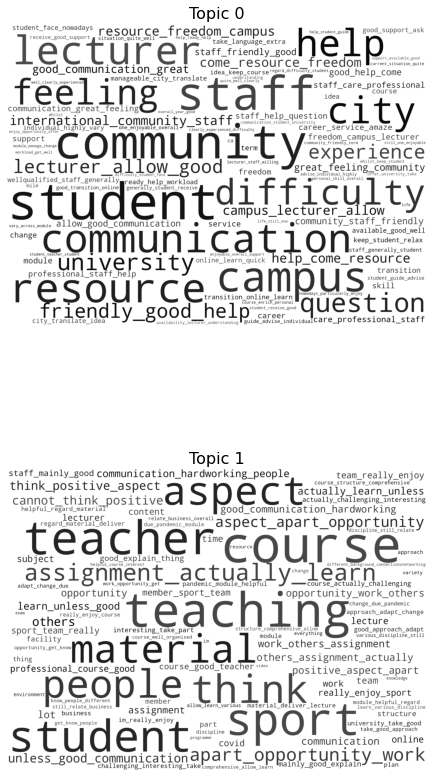

In [ ]:
# Word cloud of topics
# Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document
# Source: https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Data
topic_terms = []
for i in range(topics_df.shape[0]):
  topic_terms.append(dict(list(zip(topics_df['topicWords'][i],
                            topics_df['termWeights'][i]))))
topic_trigrams = [{key: value for key, value in topic.items() if len(key.split('_')) > 2} for topic in topic_terms]


# Configure word cloud
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  prefer_horizontal=1.0)

# Plot figure
fig, axes = plt.subplots(num_topics, 1, figsize=(7.5, num_topics*7.5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_terms[i], max_font_size=300)

  def black_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 30)

  plt.imshow(cloud.recolor(color_func=black_color_func, random_state=3),
            interpolation="bilinear")
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

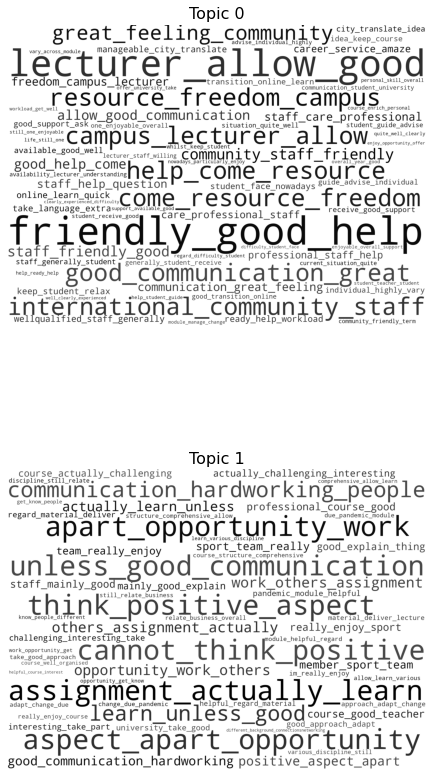

In [ ]:
# Word cloud of topics
# Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document
# Source: https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Data
topic_terms = []
for i in range(topics_df.shape[0]):
  topic_terms.append(dict(list(zip(topics_df['topicWords'][i],
                            topics_df['termWeights'][i]))))
topic_trigrams = [{key: value for key, value in topic.items() if len(key.split('_')) > 2} for topic in topic_terms]


# Configure word cloud
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  prefer_horizontal=1.0)

# Plot figure
fig, axes = plt.subplots(num_topics, 1, figsize=(7.5, num_topics*7.5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_trigrams[i], max_font_size=300)

  def black_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 30)

  plt.imshow(cloud.recolor(color_func=black_color_func, random_state=3),
            interpolation="bilinear")
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

### Dominant topics

In [ ]:
# Concatenate
classified_comments = pd.concat([input_comments, topic_dist_df], axis=1)
classified_comments.head()

,id,year,course,comment,School,sentiment,id,topic distribution,top topic
0,10,2021,ASUASC,I like some of my tutors who provided all the ...,Bayes,Positive,0,"[0.355, 0.645]",1
1,14,2021,ASUASC,"Very smoothly run, despite lockdown.",Bayes,Positive,1,"[0.955, 0.045]",0
2,15,2021,ASUASC,There are enough resources available for stude...,Bayes,Positive,2,"[0.991, 0.009]",0
3,16,2021,ASUASC,Done internship and can apply what he's/she's ...,Bayes,Positive,3,"[0.023, 0.977]",1
4,17,2021,ASUASC,"The quality of teaching for some lecturers, th...",Bayes,Positive,4,"[0.539, 0.461]",0


In [ ]:
classified_comments.dtypes

id                     int64
year                   int64
course                object
comment               object
School                object
sentiment             object
id                     int64
topic distribution    object
top topic              int64
dtype: object

In [ ]:
classified_comments.loc[classified_comments['top topic']==0]

,id,year,course,comment,School,sentiment,id,topic distribution,top topic
1,14,2021,ASUASC,"Very smoothly run, despite lockdown.",Bayes,Positive,1,"[0.955, 0.045]",0
2,15,2021,ASUASC,There are enough resources available for stude...,Bayes,Positive,2,"[0.991, 0.009]",0
4,17,2021,ASUASC,"The quality of teaching for some lecturers, th...",Bayes,Positive,4,"[0.539, 0.461]",0
8,23,2021,ASUASC,"Good quality teaching, very well balanced. Int...",Bayes,Positive,8,"[0.743, 0.257]",0
10,25,2021,ASUASC,First and most of second year.,Bayes,Positive,10,"[0.925, 0.075]",0
...,...,...,...,...,...,...,...,...,...
260,4506,2022,BUUBMT,Some of the staff are very polite and they rea...,Bayes,Positive,260,"[0.673, 0.327]",0
263,4512,2022,BUUBMT,I am glad I had the opportunity to be in a con...,Bayes,Positive,263,"[0.989, 0.011]",0
264,4513,2022,BUUBMT,The University always tried to help us have th...,Bayes,Positive,264,"[0.662, 0.338]",0
267,4518,2022,BUUBMT,Great learning opportunities.,Bayes,Positive,267,"[0.917, 0.083]",0


In [ ]:
print(classified_comments.shape)
print(classified_comments['top topic'].value_counts())
print(classified_comments['top topic'].value_counts(normalize=True) * 100)

(270, 9)
1    169
0    101
Name: top topic, dtype: int64
1    62.592593
0    37.407407
Name: top topic, dtype: float64


In [ ]:
# Random samples for selected topic
for topic in range(num_topics):

  print(f"Topic {topic}: \n")
  subset = [(i,x) for i,x in enumerate(classified_comments['topic distribution'].tolist())]
  subset = [x for x in subset if x[1][topic]>0.9]
  subset = random.sample(subset, 5)
  print(subset)
  for id in subset:
    print(classified_comments.loc[id[0], 'comment'])
  print("\n")

Topic 0: 

[(70, array([0.963, 0.037])), (252, array([0.903, 0.097])), (178, array([0.983, 0.017])), (175, array([0.99, 0.01])), (182, array([0.963, 0.037]))]
Career services are amazing.
I like my modules chosen.
Staff are caring and very professional. Staff helped me with my questions when I had them.
Many modules are more practical based vs. theory i.e., econometrics. Some lecturers and course directors true care and this showed. Core modules were good and allowed exploration of industry.
It's easy to contact the instructor when I have questions.


Topic 1: 

[(53, array([0.016, 0.984])), (244, array([0.075, 0.925])), (214, array([0.009, 0.991])), (212, array([0.031, 0.969])), (251, array([0.056, 0.944]))]
The course directors and tutors are very active and reply quickly, and hold meetings if not doing well.
I've learned a lot.
I believe the extra-academic opportunities are plenty and have been a highlight of my studies (people met, opportunities to launch things, events, etc.).
The

# Conclusion
The results presented confirm topic analysis of NSS comments is possible using LDA. Although the corpus of comments was not particularly large, as implementation utilized PySpark and Spark NLP, analyses could be scaled to larger datasets in the future. This study therefore acts a proof of concept for student feedback analyses using distributed computing.

The varying difficulty of interpreting topics generated by LDA is well documented. Nevertheless, the topics detected in this study roughly align with themes in the NSS (negative comments: assessment & feedback, teaching on my course, organisation and management; positive comments: academic support, learning community and learning opportunities). Future work should involve hyperparameter optimization using alternative evaluation metrics to perplexity (e.g. word intrusion4) and variants of LDA that are designed with short text in mind (e.g. Gibbs Sampling for Dirichlet Multinomial Mixture5). These approaches may produce more easily interpreted topic models.
